# Primitive blocks

This notebook demomstrates how to consturct composable Diagrams in Collimator. Let's implement a damped pendulum:

<img src="../media/pendulum.png" alt="pendulum" style="width: 300px;"/>

The pendulum dynamics are:

\begin{equation}
\begin{bmatrix}
\dot{\theta} \\ \dot{\omega}
\end{bmatrix} = 
\begin{bmatrix}
\omega \\ -\dfrac{g}{L} \sin(\theta) - \dfrac{b}{m L^2} \omega +  \dfrac{u}{m L^2}
\end{bmatrix}.
\end{equation}

It has a continuous vector state of size 2 (angle $\theta$ and angular velocity $\omega = \dot{\theta}$) and a torque input $u=\tau$. The pendulum parameters are mass $m$, length $L$, damping coefficients $b$, and acceleration due to gravity $g$. The output of the system is the full state $[\theta, \omega]$.

Using primitive blocks, one way to implement a block diagram implementing the above equations is shown below.

<img src="../media/pendulum-plant.png" alt="Oscillator" style="width: 800px;"/>

We can create the above diagram in code using the Collimator's primitive blocks of `Integrator`, `Gain`, `Adder`, `Demultiplexer`, and `Trigonometric` blocks. This is shown below.


In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

import collimator
from collimator import DiagramBuilder
from collimator.library import *
from collimator.simulation import ODESolverOptions

In [2]:
def make_pendulum(
    x0=[1.0, 0.0],
    m=1.0,
    g=9.81,
    L=1.0,
    b=0.0,
    name="pendulum",
):
    """
    Model of a pendulum's dynamics with damping and external torque.

    Equations of motion:
    𝜃̇ = ω
    ω̇ = -g/L * sin(𝜃) - b/(mL²) * ω + 1/(mL²) * τ


    where:
    - 𝜃 (theta) is the angular displacement,
    - ω (omega) is the angular velocity,
    - g is the acceleration due to gravity,
    - L is the length of the pendulum,
    - b is the damping coefficient,
    - m is the mass of the pendulum,
    - τ (tau) is the external torque.

    The output is the full state [𝜃, ω] .
    """
    builder = DiagramBuilder()

    Integrator_0 = builder.add(Integrator(x0, name="Integrator_0"))
    Demux_0 = builder.add(Demultiplexer(2, name="Demux_0"))
    builder.connect(Integrator_0.output_ports[0], Demux_0.input_ports[0])

    Sine_0 = builder.add(Trigonometric("sin", name="Sine_0"))
    builder.connect(Demux_0.output_ports[0], Sine_0.input_ports[0])

    Gain_0 = builder.add(Gain(-g / L, name="Gain_0"))
    builder.connect(Sine_0.output_ports[0], Gain_0.input_ports[0])

    # Damping
    Gain_1 = builder.add(Gain(-b / m / L / L, name="Gain_1"))
    builder.connect(Demux_0.output_ports[1], Gain_1.input_ports[0])

    Adder_0 = builder.add(Adder(2, name="Adder_0"))
    builder.connect(Gain_0.output_ports[0], Adder_0.input_ports[0])
    builder.connect(Gain_1.output_ports[0], Adder_0.input_ports[1])

    # Add an optional torque input
    Gain_2 = builder.add(Gain(1.0 / m / L / L, name="Gain_2"))

    Adder_1 = builder.add(Adder(2, name="Adder_1"))
    builder.connect(Adder_0.output_ports[0], Adder_1.input_ports[0])
    builder.connect(Gain_2.output_ports[0], Adder_1.input_ports[1])

    Mux_0 = builder.add(Multiplexer(2, name="Mux_0"))
    builder.connect(Demux_0.output_ports[1], Mux_0.input_ports[0])
    builder.connect(Adder_1.output_ports[0], Mux_0.input_ports[1])
    builder.connect(Mux_0.output_ports[0], Integrator_0.input_ports[0])

    # Diagram-level inport
    builder.export_input(Gain_2.input_ports[0])

    # Full state-output
    builder.export_output(Integrator_0.output_ports[0])

    return builder.build(name=name)

In [3]:
pendulum = make_pendulum()
pendulum.pprint()

│── pendulum <Diagram>
    │── Integrator_0 <Integrator> [out_0 → Demux_0.in_0]
    │── Demux_0 <Demultiplexer> [out_0 → Sine_0.in_0, out_1 → Gain_1.in_0, out_1 → Mux_0.in_0]
    │── Sine_0 <Trigonometric> [out_0 → Gain_0.in_0]
    │── Gain_0 <Gain> [out_0 → Adder_0.in_0]
    │── Gain_1 <Gain> [out_0 → Adder_0.in_1]
    │── Adder_0 <Adder> [out_0 → Adder_1.in_0]
    │── Gain_2 <Gain> [out_0 → Adder_1.in_1]
    │── Adder_1 <Adder> [out_0 → Mux_0.in_1]
    │── Mux_0 <Multiplexer> [out_0 → Integrator_0.in_0]


## Simulating the system

The above `pendulum` plant can be simulated on its own. We just need to provide an input. Let's simulate the pendulum by fixing the input torque to zero.

collimator:INFO max_major_steps=200 by default since no discrete period in system
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=200, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=1, return_context=True), Dopri5Solver(system=Diagram(pendulum, 9 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


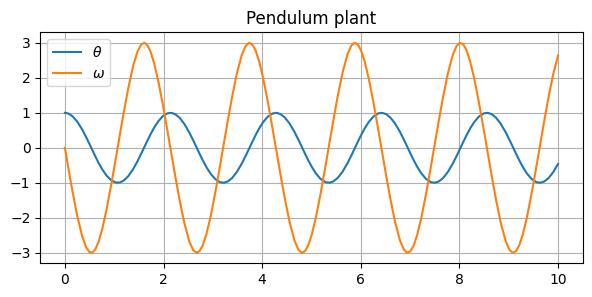

In [4]:
from collimator import SimulatorOptions

pendulum.input_ports[0].fix_value(0.0)
context = pendulum.create_context()

recorded_signals = {
    "theta_omega": pendulum["Integrator_0"].output_ports[0],
}

sol = collimator.simulate(
    pendulum,
    context,
    (0.0, 10.0),
    options=SimulatorOptions(atol=1e-8, rtol=1e-6),
    recorded_signals=recorded_signals,
)

plt.figure(figsize=(7, 3))
plt.plot(sol.time, sol.outputs["theta_omega"], label=[r"$\theta$", r"$\omega$"])
plt.legend()
plt.title("Pendulum plant")
plt.grid()
plt.show()

## Composing with other blocks

We may also compose the above pendulum plant with other blocks. For example, we can provide a sinusoidal input to the pendulum as follows.

### Sinusoidal torque input

collimator:INFO max_major_steps=200 by default since no discrete period in system
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=200, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=0.01, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=1, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=0.01, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


│── root <Diagram>
    │── pendulum <Diagram>
        │── Integrator_0 <Integrator> [out_0 → Demux_0.in_0]
        │── Demux_0 <Demultiplexer> [out_0 → Sine_0.in_0, out_1 → Gain_1.in_0, out_1 → Mux_0.in_0]
        │── Sine_0 <Trigonometric> [out_0 → Gain_0.in_0]
        │── Gain_0 <Gain> [out_0 → Adder_0.in_0]
        │── Gain_1 <Gain> [out_0 → Adder_0.in_1]
        │── Adder_0 <Adder> [out_0 → Adder_1.in_0]
        │── Gain_2 <Gain> [out_0 → Adder_1.in_1]
        │── Adder_1 <Adder> [out_0 → Mux_0.in_1]
        │── Mux_0 <Multiplexer> [out_0 → Integrator_0.in_0]
    │── sinusoidal_torque <Sine> [out_0 → pendulum.Gain_2_in_0]


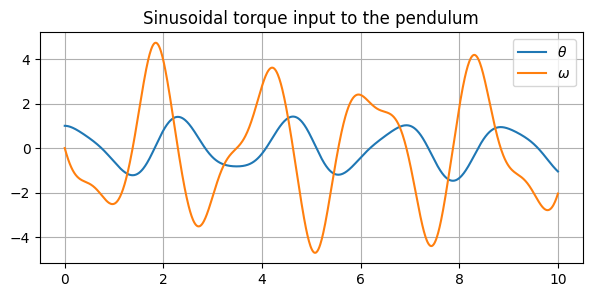

In [5]:
pendulum = make_pendulum()

builder = DiagramBuilder()
builder.add(pendulum)

sinusoidal_torque = builder.add(
    Sine(amplitude=5.0, frequency=5.0, name="sinusoidal_torque")
)

builder.connect(sinusoidal_torque.output_ports[0], pendulum.input_ports[0])
diagram = builder.build()
diagram.pprint()

context = diagram.create_context()

recorded_signals = {
    "theta_omega": pendulum["Integrator_0"].output_ports[0],
}

sol = collimator.simulate(
    diagram,
    context,
    (0.0, 10.0),
    options=SimulatorOptions(max_minor_step_size=0.01, atol=1e-8, rtol=1e-6),
    recorded_signals=recorded_signals,
)

plt.figure(figsize=(7, 3))
plt.plot(sol.time, sol.outputs["theta_omega"], label=[r"$\theta$", r"$\omega$"])
plt.legend()
plt.grid()
plt.title("Sinusoidal torque input to the pendulum")
plt.show()

### PD controller for the pendulum

As another example of composability, we demonstrate how the pendulum plant can be controlled by a PD control to drive its state to a zero vector. A PD controller block diagram is shown in below.

<img src="../media/pendulum-PD.png" alt="Oscillator" style="width: 600px;"/>

This can be implemented programatticaly as shown below.

In [6]:
pendulum = make_pendulum()

builder = DiagramBuilder()
builder.add(pendulum)

# PD feedback controller:
kp = 1.0
kd = 1.0
Demux_1 = builder.add(Demultiplexer(2, name="Demux_1"))
Gain_1 = builder.add(Gain(-kp, name="Gain_1"))
Gain_2 = builder.add(Gain(-kd, name="Gain_2"))
Adder_1 = builder.add(Adder(2, name="Adder_1"))
builder.connect(pendulum.output_ports[0], Demux_1.input_ports[0])
builder.connect(Demux_1.output_ports[0], Gain_1.input_ports[0])
builder.connect(Demux_1.output_ports[1], Gain_2.input_ports[0])
builder.connect(Gain_1.output_ports[0], Adder_1.input_ports[0])
builder.connect(Gain_2.output_ports[0], Adder_1.input_ports[1])
builder.connect(Adder_1.output_ports[0], pendulum.input_ports[0])

diagram = builder.build()
diagram.pprint()

│── root <Diagram>
    │── pendulum <Diagram> [Integrator_0_out_0 → Demux_1.in_0]
        │── Integrator_0 <Integrator> [out_0 → Demux_0.in_0]
        │── Demux_0 <Demultiplexer> [out_0 → Sine_0.in_0, out_1 → Gain_1.in_0, out_1 → Mux_0.in_0]
        │── Sine_0 <Trigonometric> [out_0 → Gain_0.in_0]
        │── Gain_0 <Gain> [out_0 → Adder_0.in_0]
        │── Gain_1 <Gain> [out_0 → Adder_0.in_1]
        │── Adder_0 <Adder> [out_0 → Adder_1.in_0]
        │── Gain_2 <Gain> [out_0 → Adder_1.in_1]
        │── Adder_1 <Adder> [out_0 → Mux_0.in_1]
        │── Mux_0 <Multiplexer> [out_0 → Integrator_0.in_0]
    │── Demux_1 <Demultiplexer> [out_0 → Gain_1.in_0, out_1 → Gain_2.in_0]
    │── Gain_1 <Gain> [out_0 → Adder_1.in_0]
    │── Gain_2 <Gain> [out_0 → Adder_1.in_1]
    │── Adder_1 <Adder> [out_0 → pendulum.Gain_2_in_0]


collimator:INFO max_major_steps=200 by default since no discrete period in system
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=200, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=1, return_context=True), Dopri5Solver(system=Diagram(root, 5 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


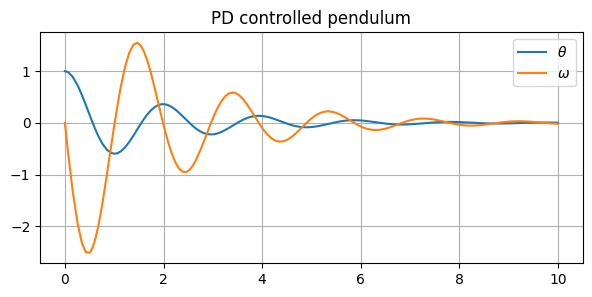

In [7]:
context = diagram.create_context()

recorded_signals = {
    "theta_omega": pendulum["Integrator_0"].output_ports[0],
}

sol = collimator.simulate(
    diagram,
    context,
    (0.0, 10.0),
    options=SimulatorOptions(atol=1e-8, rtol=1e-6),
    recorded_signals=recorded_signals,
)

plt.figure(figsize=(7, 3))
plt.plot(sol.time, sol.outputs["theta_omega"], label=[r"$\theta$", r"$\omega$"])
plt.legend()
plt.grid()
plt.title("PD controlled pendulum")
plt.show()

We see that the PD controller does indeed drives the Pendulum state to a zero vector.